In [1]:
import numpy as np
import torch
import torch.optim as optim
import os
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [2]:
# Load the data from file for 5DL1 promoter 
data=np.load("science_data_5DL1.npy")

# Extract x and y data
x_data = data[:, 0]
y_data = data[:, 1]

# Get unique x values and their corresponding indices
unique_x, unique_indices = np.unique(x_data, return_index=True)

# Extract unique y values based on unique indices
unique_y = y_data[unique_indices]

# Create unique data array with x and y values
unique_data = np.column_stack((unique_x, unique_y))

# Convert mean and variance data to torch tensors
mean_data = torch.from_numpy(unique_data[:, 0]).double()
var_data = mean_data * torch.from_numpy(unique_data[:, 1]).double()

In [5]:
# Stoichiometric matrix defining the effect of each reaction on the system
stoic_matrix = torch.tensor([[2.0, 0.0],    # Reaction 1: Promoter state goes from -1 to +1
                             [0.0, 1.0],    # Reaction 2: mRNA is produced
                             [-2.0, 0.0],   # Reaction 3: Promoter state goes from +1 to -1
                             [0.0, -1.0]])  # Reaction 4: Degradation of mRNA

device = 'cpu'

def propensities(levels, poff, r, g):
    promoter, mRNA = levels
    k_on = (1.0 - poff) / poff

    # Use `.float()` and ensure all terms are 0-dim tensors
    a1 = (k_on * (promoter == -1).float()).reshape(())
    a2 = (r * (promoter == -1).float()).reshape(())
    a3 = (1.0 * (promoter == +1).float()).reshape(())
    a4 = (g * mRNA).reshape(())

    return torch.stack([a1, a2, a3, a4])

def run_trajectories(poff, r, g, num_simulations):
    all_trajectories = []
    final_states = []
    
    for _ in range(num_simulations):
        levels = torch.tensor([-1.0, 0.0], device=device)
        t = 0.0
        trajectory = []

        while t < sim_time:
            a = torch.relu(propensities(levels, poff, r, g))
            a0 = a.sum()

            if a0.item() <= 1e-8:
                break

            tau = -torch.log(torch.rand(1, device=device)) / a0
            probs = a / a0
            j = torch.multinomial(probs, 1).item()

            trajectory.append((levels.clone(), j, tau.item()))
            levels = levels + stoic_matrix[j]
            levels[1] = torch.relu(levels[1])
            t += tau.item()

        all_trajectories.append(trajectory)
        final_states.append(levels[1])

    final_states = torch.stack(final_states)
    mean_mRNA = final_states.mean()
    variance = final_states.var(unbiased=False)

    return all_trajectories, mean_mRNA, variance

        
def reinforce_estimate(poff, r, g, mean_data, var_data, num_simulations):
    total_grad_poff = 0.0
    total_grad_r = 0.0
    total_grad_g = 0.0

    # Sample trajectories once
    all_trajectories, mean_mRNA, variance = run_trajectories(poff, r, g, num_simulations)

    # Reward based on both mean and variance
    loss = (mean_mRNA - mean_data) ** 2 + (torch.sqrt(variance) - torch.sqrt(var_data)) ** 2

    # Pick one trajectory (e.g. the first one) for REINFORCE
    trajectory = all_trajectories[0]

    eps = 1e-8
    log_grad = 0.0

    poff_, r_, g_ = poff.clone().detach().requires_grad_(), r.clone().detach().requires_grad_(), g.clone().detach().requires_grad_()

    for (x_prev, j, tau) in trajectory:
        a = torch.relu(propensities(x_prev, poff_, r_, g_))
        a0 = a.sum()
        aj = a[j]

        d_aj = torch.autograd.grad(aj, (poff_, r_, g_), retain_graph=True, allow_unused=True)
        d_a0 = torch.autograd.grad(a0, (poff_, r_, g_), retain_graph=True, allow_unused=True)

        d_aj = [g if g is not None else torch.tensor(0.0, device=poff.device) for g in d_aj]
        d_a0 = [g if g is not None else torch.tensor(0.0, device=poff.device) for g in d_a0]

        aj_safe = aj if aj.abs() > eps else eps
        log_grad_step = [daj_i / aj_safe - tau * da0_i for daj_i, da0_i in zip(d_aj, d_a0)]

        log_grad = [sum(x) for x in zip(log_grad, log_grad_step)] if isinstance(log_grad, list) else log_grad_step

    # Scale log grad by reward (loss)
    reinforce_grad = [grad_i * loss for grad_i in log_grad]

    return reinforce_grad[0], reinforce_grad[1], reinforce_grad[2], loss


# Define a function to write data to a file
def write_to_file(filename, *args):
    with open(filename, 'a') as file:
        file.write(' '.join(map(str, args)) + '\n')

# Add baseline to reinforce 

In [8]:
def reinforce_estimate_baseline(poff, r, g, mean_data, var_data, num_simulations):
    total_grad_poff = 0.0
    total_grad_r = 0.0
    total_grad_g = 0.0

    # Sample trajectories once
    all_trajectories, mean_mRNA, variance = run_trajectories(poff, r, g, num_simulations)

    # Reward based on both mean and variance
    loss = (mean_mRNA - mean_data) ** 2 + (torch.sqrt(variance) - torch.sqrt(var_data)) ** 2

    # Pick one trajectory (e.g. the first one) for REINFORCE
    trajectory = all_trajectories[0]

    #estimate the baseline
    baseline_losses = []
    for i in range(10):
        torch.manual_seed(42 + i)
        _, mean_mRNA, variance = run_trajectories(poff, r, g, 50)
        baseline_loss = (mean_mRNA - mean_data) **2 + (torch.sqrt(variance) - torch.sqrt(var_data))**2
        baseline_losses.append(baseline_loss)
    baseline = torch.mean(torch.stack(baseline_losses))

    advantage = loss - baseline

    eps = 1e-8
    log_grad = 0.0

    poff_, r_, g_ = poff.clone().detach().requires_grad_(), r.clone().detach().requires_grad_(), g.clone().detach().requires_grad_()

    for (x_prev, j, tau) in trajectory:
        a = torch.relu(propensities(x_prev, poff_, r_, g_))
        a0 = a.sum()
        aj = a[j]

        d_aj = torch.autograd.grad(aj, (poff_, r_, g_), retain_graph=True, allow_unused=True)
        d_a0 = torch.autograd.grad(a0, (poff_, r_, g_), retain_graph=True, allow_unused=True)

        d_aj = [g if g is not None else torch.tensor(0.0, device=poff.device) for g in d_aj]
        d_a0 = [g if g is not None else torch.tensor(0.0, device=poff.device) for g in d_a0]

        aj_safe = aj if aj.abs() > eps else eps
        log_grad_step = [daj_i / aj_safe - tau * da0_i for daj_i, da0_i in zip(d_aj, d_a0)]

        log_grad = [sum(x) for x in zip(log_grad, log_grad_step)] if isinstance(log_grad, list) else log_grad_step

    # Scale log grad by reward (loss) - multiply by advantage instead of raw loss
    reinforce_grad = [grad_i * advantage for grad_i in log_grad]

    return reinforce_grad[0], reinforce_grad[1], reinforce_grad[2], loss

## Adam optimizer 

In [86]:
#parameters
# Set seed for reproducibility 
torch.manual_seed(42)

# Define simulation hyperparameters
num_iterations = 500
num_simulations = 500
sim_time = 0.2

poff_values = torch.nn.Parameter(torch.linspace(0.03, 0.97, len(unique_data)))
r = torch.nn.Parameter((1e+2) * torch.rand(1))
g = torch.nn.Parameter((1e+1) * torch.rand(1))
optimizer = optim.Adam([poff_values, r, g], lr = 0.1)

#save to file
filename1 = "reinforce_poff_500.txt"
filename2 = "reinforce_main_500.txt"
#filename1 = "reinforce_poff_baseline_2502.txt"
#filename2 = "reinforce_main_baseline_2502.txt"
if os.path.exists(filename1):
    os.remove(filename1)
if os.path.exists(filename2):
    os.remove(filename2)

for iteration in tqdm(range(num_iterations)):
    optimizer.zero_grad()

    grad_poff = torch.zeros_like(poff_values)
    #grad_r = 0.0
    #grad_g = 0.0
    grad_r = torch.zeros_like(r)
    grad_g = torch.zeros_like(g)
    total_loss = 0.0

    for i in range(len(unique_data)):
        dp, dr, dg, loss = reinforce_estimate(poff_values[i], r, g, mean_data[i], var_data[i], num_iterations)
        grad_poff[i] = dp
        grad_r += dr
        grad_g += dg
        total_loss += loss

    grad_r /= len(unique_data)
    grad_g /= len(unique_data)
    total_loss /= len(unique_data)

    poff_values.grad = grad_poff
    r.grad = grad_r
    g.grad = grad_g

    torch.nn.utils.clip_grad_norm_([poff_values, r, g], max_norm=1.0)
    optimizer.step()

    # Clamp and sort as in original
    with torch.no_grad():
        r.data.clamp_(min=1.0)
        g.data.clamp_(min=1.0, max=r.item())
        poff_values.data.clamp_(min=0.01, max=0.98)
        poff_values.data, _ = torch.sort(poff_values.data)

    # Save every 10 iterations
    if iteration % 10 == 0:
        print(f"Epoch {iteration}: Loss = {total_loss.item():.4f}")
        write_to_file(filename2, iteration, r.item(), g.item(), r.item() / g.item(), total_loss.item())
        write_to_file(filename1, poff_values.tolist(), total_loss.item())


  0%|                                         | 1/500 [00:11<1:36:28, 11.60s/it]

Epoch 0: Loss = 27.5734


  2%|▉                                       | 11/500 [02:00<1:24:02, 10.31s/it]

Epoch 10: Loss = 19.4080


  4%|█▋                                      | 21/500 [03:29<1:09:21,  8.69s/it]

Epoch 20: Loss = 10.0494


  6%|██▍                                     | 31/500 [05:00<1:12:07,  9.23s/it]

Epoch 30: Loss = 15.3476


  8%|███▎                                    | 41/500 [06:36<1:14:14,  9.70s/it]

Epoch 40: Loss = 18.7291


 10%|████                                    | 51/500 [08:16<1:14:47,  9.99s/it]

Epoch 50: Loss = 18.2319


 12%|████▉                                   | 61/500 [09:55<1:11:42,  9.80s/it]

Epoch 60: Loss = 17.8145


 14%|█████▋                                  | 71/500 [11:28<1:05:24,  9.15s/it]

Epoch 70: Loss = 12.8116


 16%|██████▊                                   | 81/500 [12:55<59:35,  8.53s/it]

Epoch 80: Loss = 10.9452


 18%|███████▋                                  | 91/500 [14:16<55:17,  8.11s/it]

Epoch 90: Loss = 10.0053


 20%|████████▎                                | 101/500 [15:34<51:58,  7.82s/it]

Epoch 100: Loss = 10.5959


 22%|█████████                                | 111/500 [16:56<53:29,  8.25s/it]

Epoch 110: Loss = 13.4292


 24%|█████████▉                               | 121/500 [18:25<58:06,  9.20s/it]

Epoch 120: Loss = 13.4393


 26%|██████████▋                              | 131/500 [19:58<57:35,  9.37s/it]

Epoch 130: Loss = 13.6667


 28%|██████████▉                            | 141/500 [21:47<1:07:23, 11.26s/it]

Epoch 140: Loss = 30.5182


 30%|███████████▊                           | 151/500 [23:44<1:08:01, 11.69s/it]

Epoch 150: Loss = 33.6559


 32%|████████████▌                          | 161/500 [25:42<1:06:27, 11.76s/it]

Epoch 160: Loss = 36.1004


 34%|█████████████▎                         | 171/500 [27:40<1:04:32, 11.77s/it]

Epoch 170: Loss = 33.2456


 36%|██████████████                         | 181/500 [29:37<1:02:06, 11.68s/it]

Epoch 180: Loss = 34.2876


 38%|███████████████▋                         | 191/500 [31:28<55:59, 10.87s/it]

Epoch 190: Loss = 24.5556


 40%|████████████████▍                        | 201/500 [33:06<47:06,  9.45s/it]

Epoch 200: Loss = 16.0119


 42%|█████████████████▎                       | 211/500 [34:36<43:03,  8.94s/it]

Epoch 210: Loss = 13.8061


 44%|██████████████████                       | 221/500 [35:59<37:39,  8.10s/it]

Epoch 220: Loss = 8.3923


 46%|██████████████████▉                      | 231/500 [37:17<34:22,  7.67s/it]

Epoch 230: Loss = 6.6859


 48%|███████████████████▊                     | 241/500 [38:24<27:09,  6.29s/it]

Epoch 240: Loss = 3.3823


 50%|████████████████████▌                    | 251/500 [39:19<23:22,  5.63s/it]

Epoch 250: Loss = 3.7505


 52%|█████████████████████▍                   | 261/500 [40:24<26:03,  6.54s/it]

Epoch 260: Loss = 3.2711


 54%|██████████████████████▏                  | 271/500 [41:26<22:36,  5.92s/it]

Epoch 270: Loss = 0.9063


 56%|███████████████████████                  | 281/500 [42:24<22:09,  6.07s/it]

Epoch 280: Loss = 1.7271


 58%|███████████████████████▊                 | 291/500 [43:20<18:35,  5.34s/it]

Epoch 290: Loss = 5.0038


 60%|████████████████████████▋                | 301/500 [44:15<18:43,  5.64s/it]

Epoch 300: Loss = 3.9620


 62%|█████████████████████████▌               | 311/500 [45:19<21:39,  6.88s/it]

Epoch 310: Loss = 5.2482


 64%|██████████████████████████▎              | 321/500 [46:30<20:15,  6.79s/it]

Epoch 320: Loss = 3.6980


 66%|███████████████████████████▏             | 331/500 [47:33<17:57,  6.37s/it]

Epoch 330: Loss = 2.3523


 68%|███████████████████████████▉             | 341/500 [48:43<18:49,  7.10s/it]

Epoch 340: Loss = 3.6041


 70%|████████████████████████████▊            | 351/500 [49:57<18:24,  7.41s/it]

Epoch 350: Loss = 7.0361


 72%|█████████████████████████████▌           | 361/500 [51:12<17:34,  7.59s/it]

Epoch 360: Loss = 6.8498


 74%|██████████████████████████████▍          | 371/500 [52:23<15:09,  7.05s/it]

Epoch 370: Loss = 4.5449


 76%|███████████████████████████████▏         | 381/500 [53:34<13:58,  7.05s/it]

Epoch 380: Loss = 5.8746


 78%|████████████████████████████████         | 391/500 [54:41<12:08,  6.69s/it]

Epoch 390: Loss = 3.1966


 80%|████████████████████████████████▉        | 401/500 [55:53<12:24,  7.52s/it]

Epoch 400: Loss = 6.0152


 82%|█████████████████████████████████▋       | 411/500 [57:13<11:41,  7.88s/it]

Epoch 410: Loss = 6.6824


 84%|██████████████████████████████████▌      | 421/500 [58:40<11:52,  9.02s/it]

Epoch 420: Loss = 16.1868


 86%|█████████████████████████████████▌     | 431/500 [1:00:14<10:47,  9.38s/it]

Epoch 430: Loss = 18.1487


 88%|██████████████████████████████████▍    | 441/500 [1:01:51<09:41,  9.85s/it]

Epoch 440: Loss = 24.0596


 90%|███████████████████████████████████▏   | 451/500 [1:03:33<08:16, 10.14s/it]

Epoch 450: Loss = 23.2977


 92%|███████████████████████████████████▉   | 461/500 [1:05:12<06:24,  9.85s/it]

Epoch 460: Loss = 19.8424


 94%|████████████████████████████████████▋  | 471/500 [1:06:52<04:51, 10.07s/it]

Epoch 470: Loss = 22.5697


 96%|█████████████████████████████████████▌ | 481/500 [1:08:35<03:16, 10.36s/it]

Epoch 480: Loss = 22.0834


 98%|██████████████████████████████████████▎| 491/500 [1:10:16<01:29,  9.91s/it]

Epoch 490: Loss = 15.7264


100%|███████████████████████████████████████| 500/500 [1:11:44<00:00,  8.61s/it]


### value extraction for REINFORCE

In [21]:
data = np.loadtxt("reinforce_main_500.txt")
row_index = np.argmin(data[:, -1])
r_best = data[row_index, 1]
g_best = data[row_index, 2]

poff_values = []
with open("reinforce_poff_500.txt", "r") as file:
    for line in file:
        list_str = line.rsplit(' ', 1)[0]
        list_str = list_str.strip('[').strip(']')
        str_values = list_str.split(',')
        row = [float(value) for value in str_values]
        poff_values.append(row)

poff_values = poff_values[row_index][:len(unique_data)]


### value extraction after baseline

In [24]:
data_b = np.loadtxt("reinforce_main_baseline_250.txt")
row_index_b = np.argmin(data_b[:, -1])
r_b = data_b[row_index_b, 1]
g_b = data_b[row_index_b, 2]

poff_values_b = []
with open("reinforce_poff_baseline_250.txt", "r") as file:
    for line in file:
        list_str = line.rsplit(' ', 1)[0]
        list_str = list_str.strip('[').strip(']')
        str_values = list_str.split(',')
        row = [float(value) for value in str_values]
        poff_values_b.append(row)

poff_values_b = poff_values_b[row_index_b][:len(unique_data)]

# Checking Correctness of run_trajectories function

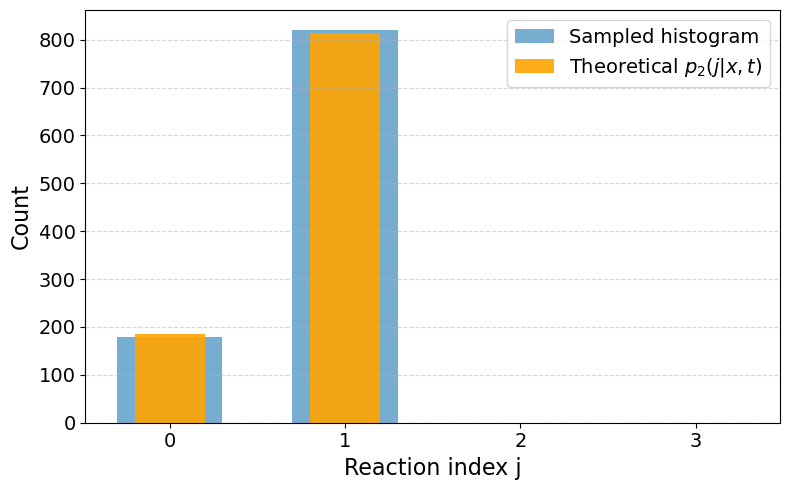

In [44]:
# Parameters (optimized parameters chosen from the paper)
kon_check = 0.87
r_check = torch.tensor(3.83, device=device)
g_check = torch.tensor(2.43, device=device)
poff_check = torch.tensor(1 / (1 + kon_check), device=device)

# Settings
num_samples = 1000
sampled_j = []

# Run only ONE Gillespie step many times (the inner loop of run_trajectories)
for _ in range(num_samples):
    # Initial state
    levels = torch.tensor([-1.0, 0.0], device=device)  # promoter OFF, 0 mRNA

    # Compute propensities
    a = torch.relu(propensities(levels, poff_check, r_check, g_check)) 
    a0 = a.sum()
    
    if a0.item() <= 1e-8:
        continue
    
    probs = a / a0

    if not torch.all(torch.isfinite(probs)) or torch.any(probs < 0):
        continue

    # Sample reaction index j
    j = torch.multinomial(probs, 1).item()
    sampled_j.append(j)

# Theoretical distribution
p_theoretical = (a / a0).cpu().numpy()

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Sampled histogram
ax.hist(sampled_j, bins=range(5), align='left', rwidth=0.6, alpha=0.6, label='Sampled histogram')

# Theoretical p2(j|x,t)
ax.bar(range(4), p_theoretical * len(sampled_j), width=0.4, color='orange', alpha=0.9, label='Theoretical $p_2(j|x,t)$')

ax.set_xlabel("Reaction index j", fontsize=16)
ax.set_ylabel("Count", fontsize = 16)
#ax.set_title("Validation of run_trajectories (1-step only)")
ax.set_xticks(range(4))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend(fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("run_trajectories_check.png", dpi=150)
plt.show()




# Plots

## Import all DGA data

In [36]:
# Find the row index with minimum loss value. 
data_dga=np.loadtxt("learning_science_5DL1_250.txt")
row_index_dga = np.argmin(data_dga[:, -1])
r_dga=data_dga[row_index_dga,1]
g_dga=data_dga[row_index_dga, 2]

# Path to poff_values
file_path_dga = 'learning_science_5DL1_poff_250.txt'

# Initialize an empty list to store rows
poff_values_dga = []

with open(file_path_dga, 'r') as file:
    for line in file:
        # Remove the trailing number by splitting at the last space and taking the first part
        list_str = line.rsplit(' ', 1)[0]
        # Remove surrounding brackets
        list_str = list_str.strip('[').strip(']')
        # Split the remaining string by commas to form a list of strings
        str_values = list_str.split(',')
        # Convert strings to floats
        row = [float(value) for value in str_values]
        # Append the row to our data list
        poff_values_dga.append(row)
  
poff_values_dga = poff_values_dga[row_index_dga][:len(unique_data)] 

## Import RLOO Data

In [39]:
data_rloo = np.loadtxt("RLOO_main_250.txt")
row_index = np.argmin(data_rloo[:, -1])
r_rloo = data_rloo[row_index, 1]
g_rloo = data_rloo[row_index, 2]

poff_values_rloo = []
with open("RLOO_poff_250.txt", "r") as file:
    for line in file:
        list_str = line.rsplit(' ', 1)[0]
        list_str = list_str.strip('[').strip(']')
        str_values = list_str.split(',')
        row = [float(value) for value in str_values]
        poff_values_rloo.append(row)

poff_values_rloo = poff_values_rloo[row_index][:len(unique_data)]

## 1. mean vs fano factor 

Find the theoretical mean and fano factor by running the gillespie simulation with the values that have been found through the optimization. 

plot experimental value, DGA prediction and reinforce prediction

### REINFORCE

In [45]:
#simulation data
poff_range = torch.linspace(0.005, 0.97, 500)
k_off = 1

mean_expression = []
fano_factors = []
for i in poff_range:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_best/g_best
    mean_expression.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_best / (k_on + k_off+g_best))
    fano_factors.append(f)

#convert to numpy 
mean_expression = torch.tensor(mean_expression).detach().numpy()
fano_factors = torch.tensor(fano_factors).detach().numpy()

### REINFORCE with Baseline

In [48]:
#with baseline
poff_range_b = torch.linspace(0.005, 0.97, 500)
k_off = 1

mean_expression_b = []
fano_factors_b = []
for i in poff_range_b:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_b/g_b
    mean_expression_b.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_b / (k_on + k_off+g_b))
    fano_factors_b.append(f)

#convert to numpy 
mean_expression_b = torch.tensor(mean_expression_b).detach().numpy()
fano_factors_b = torch.tensor(fano_factors_b).detach().numpy()


### Experimental Data

In [51]:
#experimental data
fano_factor_exp = var_data / mean_data

# Calculate standard error for plotting (optional, adjust as needed)
std_mRNA = np.sqrt(mean_data)/np.sqrt(17)  # or from your data
std_fano = np.sqrt(fano_factor_exp)/np.sqrt(17)  # or from variance propagation

### DGA data

In [54]:
#simulation data
poff_range_dga = torch.linspace(0.005, 0.97, 500)
k_off = 1

mean_expression_dga = []
fano_factors_dga = []
for i in poff_range_dga:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_dga/g_dga
    mean_expression_dga.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_dga / (k_on + k_off+g_dga))
    fano_factors_dga.append(f)

### RLOO

In [57]:
#simulation data
poff_range_rloo = torch.linspace(0.005, 0.97, 500)
k_off = 1

mean_expression_rloo = []
fano_factors_rloo = []
for i in poff_range_rloo:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_rloo/g_rloo
    mean_expression_rloo.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_rloo / (k_on + k_off+g_rloo))
    fano_factors_rloo.append(f)

#convert to numpy 
mean_expression_rloo = torch.tensor(mean_expression_rloo).detach().numpy()
fano_factors_rloo = torch.tensor(fano_factors_rloo).detach().numpy()

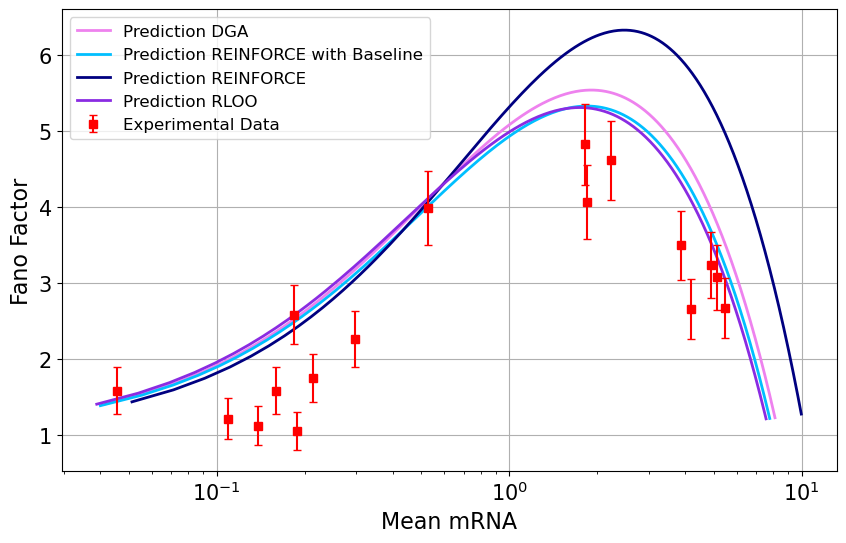

In [63]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(mean_expression_dga, fano_factors_dga, label="Prediction DGA", linewidth=2, color ="violet")
#plt.scatter(mean_data, fano_factor_exp, color = "red", label = "Experimental Data", marker = "s")
plt.plot(mean_expression_b, fano_factors_b, label="Prediction REINFORCE with Baseline", linewidth=2, color ="deepskyblue")
plt.plot(mean_expression, fano_factors, label="Prediction REINFORCE", linewidth=2, color ="navy")
plt.plot(mean_expression_rloo, fano_factors_rloo, label="Prediction RLOO", linewidth=2, color ="blueviolet")
#plt.plot(mean_expression_rloo, fano_factors_rloo, label="Prediction RLOO", linewidth=2, color ="red")
plt.errorbar(mean_data, fano_factor_exp, yerr=std_fano, fmt='s', color='red', ecolor='red', capsize=3, label = "Experimental Data")
plt.xlabel("Mean mRNA", fontsize = 16)
plt.ylabel("Fano Factor", fontsize = 16)
plt.xscale('log')
plt.legend(fontsize = 12, loc = "upper left")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.savefig("mean_vs_fano.png", dpi=150)
plt.show()

# Testing lacUD5 (second mRNA)

In [71]:
# Load the data from file for lacUD5 promoter 
data=np.load("science_data_lacUD5.npy")

# Extract x and y data
x_data = data[:, 0]
y_data = data[:, 1]

# Get unique x values and their corresponding indices
unique_x, unique_indices = np.unique(x_data, return_index=True)

# Extract unique y values based on unique indices
unique_y = y_data[unique_indices]

# Create unique data array with x and y values
unique_data_lacUD5 = np.column_stack((unique_x, unique_y))

# Convert mean and variance data to torch tensors
mean_data_lacUD5 = torch.from_numpy(unique_data_lacUD5[:, 0]).double()
var_data_lacUD5 = mean_data_lacUD5 * torch.from_numpy(unique_data_lacUD5[:, 1]).double()

# Adam Optimizer

In [84]:
#parameters
# Set seed for reproducibility 
torch.manual_seed(42)

# Define simulation hyperparameters
num_iterations = 500
num_simulations = 250
sim_time = 0.2

poff_values = torch.nn.Parameter(torch.linspace(0.03, 0.97, len(unique_data_lacUD5)))
r = torch.nn.Parameter((1e+2) * torch.rand(1))
g = torch.nn.Parameter((1e+1) * torch.rand(1))
optimizer = optim.Adam([poff_values, r, g], lr = 0.01)

#save to file
filename1 = "reinforce_poff_lacUD5_500.txt"
filename2 = "reinforce_main_lacUD5_500.txt"
#filename1 = "reinforce_poff_baseline_lacUD5_501.txt"
#filename2 = "reinforce_main_baseline_lacUD5_501.txt"
if os.path.exists(filename1):
    os.remove(filename1)
if os.path.exists(filename2):
    os.remove(filename2)

for iteration in tqdm(range(num_iterations)):
    optimizer.zero_grad()

    grad_poff = torch.zeros_like(poff_values)
    #grad_r = 0.0
    #grad_g = 0.0
    grad_r = torch.zeros_like(r)
    grad_g = torch.zeros_like(g)
    total_loss = 0.0

    for i in range(len(unique_data_lacUD5)):
        dp, dr, dg, loss = reinforce_estimate(poff_values[i], r, g, mean_data_lacUD5[i], var_data_lacUD5[i], num_simulations)
        #dp, dr, dg, loss = reinforce_estimate_baseline(poff_values[i], r, g, mean_data_lacUD5[i], var_data_lacUD5[i], num_iterations)
        grad_poff[i] = dp
        grad_r += dr
        grad_g += dg
        total_loss += loss

    grad_r /= len(unique_data_lacUD5)
    grad_g /= len(unique_data_lacUD5)
    total_loss /= len(unique_data_lacUD5)

    poff_values.grad = grad_poff
    r.grad = grad_r
    g.grad = grad_g

    torch.nn.utils.clip_grad_norm_([poff_values, r, g], max_norm=1.0)
    optimizer.step()

    # Clamp and sort as in original
    with torch.no_grad():
        r.data.clamp_(min=1.0)
        g.data.clamp_(min=1.0, max=r.item())
        poff_values.data.clamp_(min=0.01, max=0.98)
        poff_values.data, _ = torch.sort(poff_values.data)

    # Save every 10 iterations
    if iteration % 10 == 0:
        print(f"Epoch {iteration}: Loss = {total_loss.item():.4f}")

    if iteration %1 == 0:
        write_to_file(filename2, iteration, r.item(), g.item(), r.item() / g.item(), total_loss.item())
        write_to_file(filename1, poff_values.tolist(), total_loss.item())


  0%|                                           | 1/500 [00:02<20:24,  2.45s/it]

Epoch 0: Loss = 24.8197


  2%|▉                                         | 11/500 [00:25<18:43,  2.30s/it]

Epoch 10: Loss = 24.2386


  4%|█▊                                        | 21/500 [00:48<18:09,  2.28s/it]

Epoch 20: Loss = 25.6093


  6%|██▌                                       | 31/500 [01:11<17:39,  2.26s/it]

Epoch 30: Loss = 24.8686


  8%|███▍                                      | 41/500 [01:34<17:28,  2.28s/it]

Epoch 40: Loss = 25.9189


 10%|████▎                                     | 51/500 [01:56<17:07,  2.29s/it]

Epoch 50: Loss = 26.5883


 12%|█████                                     | 61/500 [02:19<16:51,  2.30s/it]

Epoch 60: Loss = 24.9015


 14%|█████▉                                    | 71/500 [02:43<16:59,  2.38s/it]

Epoch 70: Loss = 24.7505


 16%|██████▏                               | 81/500 [28:56<30:41:53, 263.76s/it]

Epoch 80: Loss = 24.1869


 18%|███████▎                                | 91/500 [29:19<1:06:07,  9.70s/it]

Epoch 90: Loss = 24.3093


 20%|████████▎                                | 101/500 [29:42<16:25,  2.47s/it]

Epoch 100: Loss = 22.9931


 22%|█████████                                | 111/500 [30:04<14:25,  2.22s/it]

Epoch 110: Loss = 22.2490


 24%|█████████▉                               | 121/500 [30:26<14:04,  2.23s/it]

Epoch 120: Loss = 21.5716


 26%|██████████▋                              | 131/500 [30:49<13:47,  2.24s/it]

Epoch 130: Loss = 20.4640


 28%|███████████▌                             | 141/500 [31:11<13:28,  2.25s/it]

Epoch 140: Loss = 22.6709


 30%|████████████▍                            | 151/500 [31:34<13:00,  2.24s/it]

Epoch 150: Loss = 21.5461


 32%|█████████████▏                           | 161/500 [31:56<12:47,  2.26s/it]

Epoch 160: Loss = 22.7450


 34%|██████████████                           | 171/500 [32:19<12:19,  2.25s/it]

Epoch 170: Loss = 22.1408


 36%|██████████████▊                          | 181/500 [32:42<12:05,  2.27s/it]

Epoch 180: Loss = 22.4484


 38%|███████████████▋                         | 191/500 [33:05<12:12,  2.37s/it]

Epoch 190: Loss = 22.6087


 40%|████████████████▍                        | 201/500 [33:28<11:32,  2.32s/it]

Epoch 200: Loss = 23.7279


 42%|█████████████████▎                       | 211/500 [33:52<11:36,  2.41s/it]

Epoch 210: Loss = 22.6061


 44%|██████████████████                       | 221/500 [34:16<10:57,  2.36s/it]

Epoch 220: Loss = 23.0009


 46%|██████████████████▉                      | 231/500 [34:39<10:34,  2.36s/it]

Epoch 230: Loss = 24.0016


 48%|███████████████████▊                     | 241/500 [35:03<10:09,  2.35s/it]

Epoch 240: Loss = 21.4797


 50%|████████████████████▌                    | 251/500 [35:27<09:49,  2.37s/it]

Epoch 250: Loss = 22.5766


 52%|█████████████████████▍                   | 261/500 [35:50<09:15,  2.32s/it]

Epoch 260: Loss = 22.5784


 54%|██████████████████████▏                  | 271/500 [36:14<08:53,  2.33s/it]

Epoch 270: Loss = 21.3546


 56%|███████████████████████                  | 281/500 [36:36<08:18,  2.28s/it]

Epoch 280: Loss = 21.9748


 58%|███████████████████████▊                 | 291/500 [36:59<07:48,  2.24s/it]

Epoch 290: Loss = 20.5431


 60%|████████████████████████▋                | 301/500 [37:22<07:30,  2.26s/it]

Epoch 300: Loss = 21.1296


 62%|█████████████████████████▌               | 311/500 [37:44<07:05,  2.25s/it]

Epoch 310: Loss = 19.4435


 64%|██████████████████████████▎              | 321/500 [38:07<06:43,  2.25s/it]

Epoch 320: Loss = 20.6364


 66%|███████████████████████████▏             | 331/500 [38:29<06:23,  2.27s/it]

Epoch 330: Loss = 20.8947


 68%|███████████████████████████▉             | 341/500 [38:52<06:02,  2.28s/it]

Epoch 340: Loss = 22.0545


 70%|████████████████████████████▊            | 351/500 [39:15<05:37,  2.27s/it]

Epoch 350: Loss = 22.6120


 72%|█████████████████████████████▌           | 361/500 [39:37<05:13,  2.26s/it]

Epoch 360: Loss = 20.8076


 74%|██████████████████████████████▍          | 371/500 [40:00<04:54,  2.29s/it]

Epoch 370: Loss = 20.8513


 76%|███████████████████████████████▏         | 381/500 [40:23<04:31,  2.28s/it]

Epoch 380: Loss = 21.5887


 78%|████████████████████████████████         | 391/500 [40:46<04:07,  2.27s/it]

Epoch 390: Loss = 21.9574


 80%|████████████████████████████████▉        | 401/500 [41:08<03:43,  2.26s/it]

Epoch 400: Loss = 21.7733


 82%|█████████████████████████████████▋       | 411/500 [41:31<03:19,  2.24s/it]

Epoch 410: Loss = 21.2935


 84%|██████████████████████████████████▌      | 421/500 [41:53<02:59,  2.27s/it]

Epoch 420: Loss = 22.1438


 86%|███████████████████████████████████▎     | 431/500 [42:15<02:34,  2.24s/it]

Epoch 430: Loss = 22.3234


 88%|████████████████████████████████████▏    | 441/500 [42:38<02:13,  2.26s/it]

Epoch 440: Loss = 22.6601


 90%|████████████████████████████████████▉    | 451/500 [43:00<01:50,  2.26s/it]

Epoch 450: Loss = 24.4067


 92%|█████████████████████████████████████▊   | 461/500 [43:23<01:29,  2.30s/it]

Epoch 460: Loss = 23.0673


 94%|██████████████████████████████████████▌  | 471/500 [43:46<01:06,  2.28s/it]

Epoch 470: Loss = 22.3391


 96%|███████████████████████████████████████▍ | 481/500 [44:09<00:43,  2.28s/it]

Epoch 480: Loss = 22.8193


 98%|████████████████████████████████████████▎| 491/500 [44:32<00:20,  2.29s/it]

Epoch 490: Loss = 21.6715


100%|█████████████████████████████████████████| 500/500 [44:52<00:00,  5.39s/it]


### Value extraction for REINFORCE

In [73]:
data = np.loadtxt("reinforce_main_lacUD5_200.txt")
row_index = np.argmin(data[:, -1])
r_lacUD5 = data[row_index, 1]
g_lacUD5 = data[row_index, 2]

poff_values_lacUD5 = []
with open("reinforce_poff_lacUD5_200.txt", "r") as file:
    for line in file:
        list_str = line.rsplit(' ', 1)[0]
        list_str = list_str.strip('[').strip(']')
        str_values = list_str.split(',')
        row = [float(value) for value in str_values]
        poff_values_lacUD5.append(row)

poff_values_lacUD5 = poff_values_lacUD5[row_index][:len(unique_data_lacUD5)]

### Value extraction for REINFORCE with Baseline

In [76]:
data_b = np.loadtxt("reinforce_main_baseline_lacUD5_501.txt")
row_index_b = np.argmin(data_b[:, -1])
r_b_lacUD5 = data_b[row_index_b, 1]
g_b_lacUD5 = data_b[row_index_b, 2]

poff_values_b_lacUD5 = []
with open("reinforce_poff_baseline_lacUD5_501.txt", "r") as file:
    for line in file:
        list_str = line.rsplit(' ', 1)[0]
        list_str = list_str.strip('[').strip(']')
        str_values = list_str.split(',')
        row = [float(value) for value in str_values]
        poff_values_b_lacUD5.append(row)

poff_values_b_lacUD5 = poff_values_b_lacUD5[row_index_b][:len(unique_data_lacUD5)]

### import DGA data

In [79]:
# Find the row index with minimum loss value. 
data_dga=np.loadtxt("learning_science_lacUD5_500.txt")
row_index_dga = np.argmin(data_dga[:, -1])
r_dga_lacUD5=data_dga[row_index_dga,1]
g_dga_lacUD5=data_dga[row_index_dga, 2]

# Path to poff_values
file_path_dga = 'learning_science_lacUD5_poff_500.txt'

# Initialize an empty list to store rows
poff_values_dga = []

with open(file_path_dga, 'r') as file:
    for line in file:
        # Remove the trailing number by splitting at the last space and taking the first part
        list_str = line.rsplit(' ', 1)[0]
        # Remove surrounding brackets
        list_str = list_str.strip('[').strip(']')
        # Split the remaining string by commas to form a list of strings
        str_values = list_str.split(',')
        # Convert strings to floats
        row = [float(value) for value in str_values]
        # Append the row to our data list
        poff_values_dga.append(row)
  
poff_values_dga = poff_values_dga[row_index_dga][:len(unique_data_lacUD5)] 

### import RLOO data

In [82]:
data = np.loadtxt("RLOO_main_lacUD5_100.txt")
row_index = np.argmin(data[:, -1])
r_rloo_lacUD5 = data[row_index, 1]
g_rloo_lacUD5 = data[row_index, 2]

poff_values_lacUD5 = []
with open("RLOO_poff_lacUD5_100.txt", "r") as file:
    for line in file:
        list_str = line.rsplit(' ', 1)[0]
        list_str = list_str.strip('[').strip(']')
        str_values = list_str.split(',')
        row = [float(value) for value in str_values]
        poff_values_lacUD5.append(row)

poff_values_lacUD5 = poff_values_lacUD5[row_index][:len(unique_data_lacUD5)]

## Mean vs Fano Factor

### REINFORCE

In [84]:
#simulation data
r_best = r_lacUD5
g_best = g_lacUD5

poff_range = torch.linspace(0.003, 0.97, 500)

k_off = 1

mean_expression = []
fano_factors = []
for i in poff_range:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_best/g_best
    mean_expression.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_best / (k_on + k_off+g_best))
    fano_factors.append(f)

#convert to numpy 
mean_expression = torch.tensor(mean_expression).detach().numpy()
fano_factors = torch.tensor(fano_factors).detach().numpy()

### REINFORCE with Baseline

In [87]:
#simulation data
#poff_range_b = torch.linspace(poff_values_b[0], poff_values_b[-1], 500)
poff_range_b_lacUD5  = torch.linspace(0.003, 0.97, 500)
k_off = 1

mean_expression_b_lacUD5  = []
fano_factors_b_lacUD5  = []
for i in poff_range_b_lacUD5 :
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_b_lacUD5/g_b_lacUD5
    mean_expression_b_lacUD5 .append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_b_lacUD5 / (k_on + k_off+g_b_lacUD5))
    fano_factors_b_lacUD5 .append(f)

### DGA Data

In [90]:
#simulation data
poff_range_dga = torch.linspace(0.003, 0.97, 500)
k_off = 1

mean_expression_dga = []
fano_factors_dga = []
for i in poff_range_dga:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_dga_lacUD5/g_dga_lacUD5
    mean_expression_dga.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_dga_lacUD5 / (k_on + k_off+g_dga_lacUD5))
    fano_factors_dga.append(f)



### RLOO

In [92]:
#simulation data
r_best = r_rloo_lacUD5
g_best = g_rloo_lacUD5

poff_range_rloo = torch.linspace(0.003, 0.97, 500)

k_off = 1

mean_expression_rloo = []
fano_factors_rloo = []
for i in poff_range_rloo:
    k_on = (1.0 - i) / i
    m = k_off/(k_on + k_off) * r_rloo_lacUD5/g_rloo_lacUD5
    mean_expression_rloo.append(m)
    f = 1 + (k_on/(k_on + k_off)) * (r_rloo_lacUD5 / (k_on + k_off+g_rloo_lacUD5))
    fano_factors_rloo.append(f)

#convert to numpy 
mean_expression_rloo = torch.tensor(mean_expression_rloo).detach().numpy()
fano_factors_rloo = torch.tensor(fano_factors_rloo).detach().numpy()

### Experimental Data

In [97]:
#experimental data
fano_factor_exp = var_data_lacUD5 / mean_data_lacUD5

# Calculate standard error for plotting (optional, adjust as needed)
std_mRNA = np.sqrt(mean_data_lacUD5)/np.sqrt(17)  # or from your data
std_fano = np.sqrt(fano_factor_exp)/np.sqrt(17)  # or from variance propagation

### Plot Graph

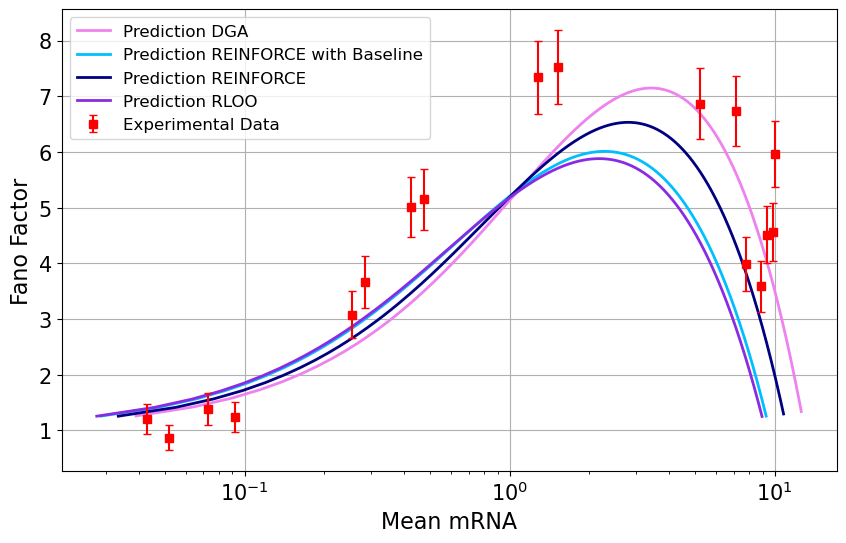

In [100]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(mean_expression_dga, fano_factors_dga, label="Prediction DGA", linewidth=2, color ="violet")
plt.plot(mean_expression_b_lacUD5 , fano_factors_b_lacUD5 , label="Prediction REINFORCE with Baseline", linewidth=2, color ="deepskyblue")
plt.plot(mean_expression, fano_factors, label="Prediction REINFORCE", linewidth=2, color ="navy")
plt.plot(mean_expression_rloo, fano_factors_rloo, label="Prediction RLOO", linewidth=2, color ="blueviolet")
plt.errorbar(mean_data_lacUD5, fano_factor_exp, yerr=std_fano, fmt='s', color='red', ecolor='red', capsize=3, label = "Experimental Data")
plt.xlabel("Mean mRNA", fontsize = 16)
plt.ylabel("Fano Factor", fontsize = 16)
plt.xscale('log')
plt.legend(fontsize = 12, loc = "upper left")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.savefig("mean_vs_fano_lacUD5.png", dpi=150)
plt.show()

# Normalized Transcription Rate (for both mRNA)

### Predicted values for 5DL1

In [131]:
#REINFORCE 
ratio_r = r_best/g_best

#REINFORCE with Baseline
ratio_b = r_b/g_b

#DGA
ratio_dga = r_dga/g_dga

#RLOO
ratio_rloo = r_rloo/g_rloo

### Experimental value for 5DL1

In [106]:
ratio_exp = 8.0

### Predicted values for lacUD5

In [104]:
#REINFORCE 
ratio_r_lacUD5 = r_lacUD5/g_lacUD5

#REINFORCE with Baseline
ratio_b_lacUD5 = r_b_lacUD5/g_b_lacUD5

#DGA
ratio_dga_lacUD5 = r_dga_lacUD5/g_dga_lacUD5

#RLOO
ratio_rloo_lacUD5 = r_rloo_lacUD5/g_rloo_lacUD5

### Experimental value for IacUD5

In [108]:
ratio_exp_lacUD5 = 15.7

### Standard Deviation of r and g

In [118]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define simulation hyperparameters
num_simulations = 200
sim_time = 0.2

def std_r(r, g, poff_values, reinforce_estimate, mean_data, var_data, unique_data, device='cpu', num_points=50, num_points2=50):
    loss_list = []

    # Generate a range of r values around the current value
    r_list = np.linspace(r - 0.8 * r, 2 * r, num_points)

    for r_value in r_list:
        r_tensor = torch.tensor([r_value], dtype=torch.float32, device=device)
        g_tensor = torch.tensor([g], dtype=torch.float32, device=device)
        poff_tensor = torch.tensor(poff_values, dtype=torch.float32, device=device)

        total_loss = 0.0

        for i in range(len(unique_data)):
            poff_i = poff_tensor[i].unsqueeze(0)
            mean_i = mean_data[i]
            var_i = var_data[i]

            _, _, _, loss = reinforce_estimate(poff_i, r_tensor, g_tensor, mean_i, var_i, num_simulations)
            total_loss += loss.item()

        avg_loss = total_loss / len(unique_data)
        loss_list.append(avg_loss)

    coeffs = np.polyfit(r_list, loss_list, deg=6)
    poly_func = np.poly1d(coeffs)
    second_derivative = np.polyder(poly_func, 2)

    evaluation_points = np.linspace(r_list[0], r_list[-1], num_points2)
    curvatures = [second_derivative(p) for p in evaluation_points]
    average_curvature = np.mean(curvatures)

    std_r_val = 1.0 / np.sqrt(abs(average_curvature))
    return std_r_val


def std_g(r, g, poff_values, reinforce_estimate, mean_data, var_data, unique_data, device='cpu', num_points=50, num_points2=50):
    loss_list = []

    g_list = np.linspace(g - 0.8 * g, 2 * g, num_points)

    for g_value in g_list:
        r_tensor = torch.tensor([r], dtype=torch.float32, device=device)
        g_tensor = torch.tensor([g_value], dtype=torch.float32, device=device)
        poff_tensor = torch.tensor(poff_values, dtype=torch.float32, device=device)

        total_loss = 0.0

        for i in range(len(unique_data)):
            poff_i = poff_tensor[i].unsqueeze(0)
            mean_i = mean_data[i]
            var_i = var_data[i]

            _, _, _, loss = reinforce_estimate(poff_i, r_tensor, g_tensor, mean_i, var_i, num_simulations)
            total_loss += loss.item()

        avg_loss = total_loss / len(unique_data)
        loss_list.append(avg_loss)

    coeffs = np.polyfit(g_list, loss_list, deg=6)
    poly_func = np.poly1d(coeffs)
    second_derivative = np.polyder(poly_func, 2)

    evaluation_points = np.linspace(g_list[0], g_list[-1], num_points2)
    curvatures = [second_derivative(p) for p in evaluation_points]
    average_curvature = np.mean(curvatures)

    std_g_val = 1.0 / np.sqrt(abs(average_curvature))
    return std_g_val


In [120]:
#values for 5DL1
std_r_reinforce = std_r(r_best, g_best, poff_values, reinforce_estimate, mean_data, var_data, unique_data)
std_g_reinforce = std_g(r_best, g_best, poff_values, reinforce_estimate, mean_data, var_data, unique_data)

In [121]:
#values for lacUD5
std_r_reinforce_lacUD5 = std_r(r_lacUD5, g_lacUD5, poff_values_lacUD5, reinforce_estimate, mean_data_lacUD5, var_data_lacUD5, unique_data_lacUD5)
std_g_reinforce_lacUD5 = std_g(r_lacUD5, g_lacUD5, poff_values_lacUD5, reinforce_estimate, mean_data_lacUD5, var_data_lacUD5, unique_data_lacUD5)

In [122]:
num_simulations = 50 

#baseline
std_r_baseline = std_r(r_b, g_b, poff_values_b, reinforce_estimate_baseline, mean_data, var_data, unique_data)
std_g_baseline = std_g(r_b, g_b, poff_values_b, reinforce_estimate_baseline, mean_data, var_data, unique_data)

std_r_baseline_lacUD5 = std_r(r_b_lacUD5, g_b_lacUD5, poff_values_b_lacUD5, reinforce_estimate_baseline, mean_data_lacUD5, var_data_lacUD5, unique_data_lacUD5)
std_g_baseline_lacUD5 = std_g(r_b_lacUD5, g_b_lacUD5, poff_values_b_lacUD5, reinforce_estimate_baseline, mean_data_lacUD5, var_data_lacUD5, unique_data_lacUD5)

### standard deviation of r/gamma using propagation error 

In [124]:
# for  5DL1
error_reinforce = (r_best/g_best) * ((std_r_reinforce/r_best)**2 + (std_g_reinforce/g_best)**2)**0.5

error_baseline = (r_b/g_b) * ((std_r_baseline/r_b)**2 + (std_g_baseline/g_b)**2)**0.5

# for lacUD5
error_reinforce_lacUD5 = (r_lacUD5/g_lacUD5) * ((std_r_reinforce_lacUD5/r_lacUD5)**2 + (std_g_reinforce_lacUD5/g_lacUD5)**2)**0.5

error_baseline_lacUD5 = (r_b_lacUD5/g_b_lacUD5) * ((std_r_baseline_lacUD5/r_b_lacUD5)**2 + (std_g_baseline_lacUD5/g_b_lacUD5)**2)**0.5


### values from DGA

In [126]:
error_dga = 2.2714915869659795
error_dga_lacUD5 = 3.012052160263097

### values from RLOO

In [128]:
error_rloo = 1.7814918891073566
error_rloo_lacUD5 = 1.7810254165954216

### Bar Plot

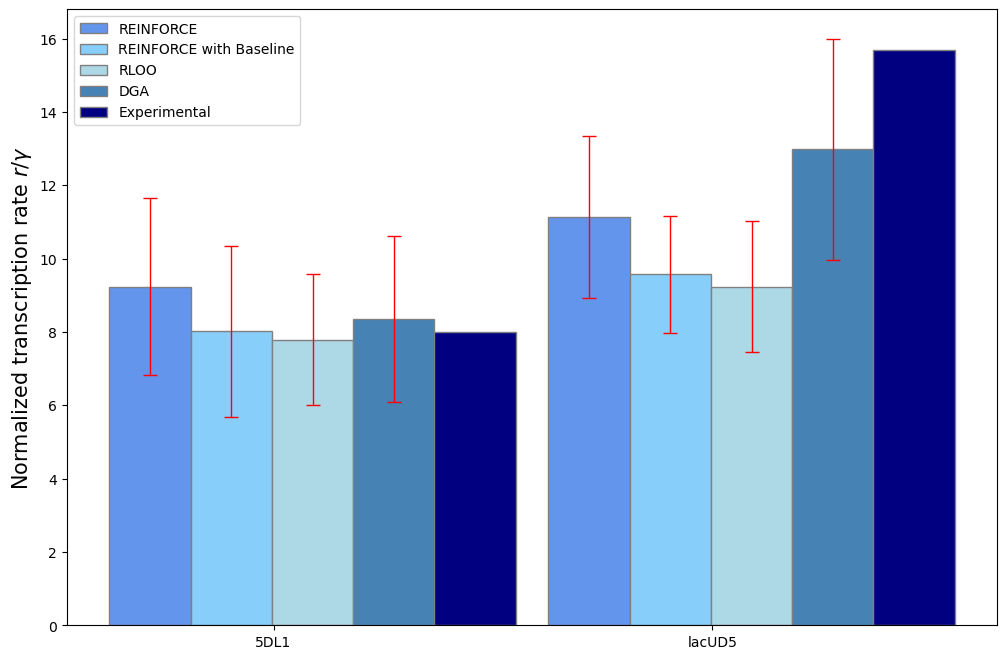

In [139]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 

R = [ratio_r, ratio_r_lacUD5] 
R_B = [ratio_b, ratio_b_lacUD5] 
DGA = [ratio_dga, ratio_dga_lacUD5] 
RLOO = [ratio_rloo, ratio_rloo_lacUD5]
exp = [ratio_exp, ratio_exp_lacUD5]

err_R = [error_reinforce, error_reinforce_lacUD5] 
err_R_B = [error_baseline, error_baseline_lacUD5] 
err_DGA = [error_dga, error_dga_lacUD5] 
err_RLOO = [error_rloo, error_rloo_lacUD5]

#br1 = np.arange(len(R)) 
group_spacing = 1.35  # try values between 1.2 and 2.0 depending on desired space
br1 = np.array([0, group_spacing])
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 
br5 = [x + barWidth for x in br4] 

plt.bar(br1, R, color ='cornflowerblue', width = barWidth, 
        edgecolor ='grey', label ='REINFORCE', yerr=err_R,
        error_kw=dict(ecolor='red', lw=1, capsize=5, capthick=1)) 
plt.bar(br2, R_B, color ='lightskyblue', width = barWidth, 
        edgecolor ='grey', label ='REINFORCE with Baseline', yerr=err_R_B,
        error_kw=dict(ecolor='red', lw=1, capsize=5, capthick=1)) 
plt.bar(br3, RLOO, color ='lightblue', width = barWidth, 
        edgecolor ='grey', label ='RLOO', yerr=err_RLOO,
        error_kw=dict(ecolor='red', lw=1, capsize=5, capthick=1)) 
plt.bar(br4, DGA, color ='steelblue', width = barWidth, 
        edgecolor ='grey', label ='DGA', yerr=err_DGA,
        error_kw=dict(ecolor='red', lw=1, capsize=5, capthick=1)) 
plt.bar(br5, exp, color ='navy', width = barWidth, 
        edgecolor ='grey', label ='Experimental') 

#plt.xlabel('Branch', fontweight ='bold', fontsize = 15) 
plt.ylabel('Normalized transcription rate $r/ \\gamma$', fontsize = 15) 
#plt.xticks([r + barWidth for r in range(len(R))], 
        #['5DL1', 'lacUD5'])
plt.xticks([barWidth+0.13, group_spacing+barWidth+0.13], 
        ['5DL1', 'lacUD5'])

plt.legend()
plt.savefig("bar_plot2.png", dpi=150)
plt.show() 